# RecDP LLM - Toxicity and Bias Control

This component will score text toxicity and bias with pre-trained BERT and Roberta model. User can use that as an indicator to decide if we should skip toxic data.

Return Value: score range from 0 - 1. Higher is more toxic

# Get Started

1.Install pyrecdp and dependencies

In [ ]:
! DEBIAN_FRONTEND=noninteractive apt-get install -qq -y openjdk-8-jre
! pip install -q pyrecdp --pre
# ! pip install 'git+https://github.com/intel/e2eAIOK.git#egg=pyrecdp&subdirectory=RecDP'

## 2. Prepare your own data

In [ ]:
%mkdir -p /content/test_data
%cd /content/test_data
!wget https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/llm_data/tiny_c4_sample.jsonl

### 3.1 Process with TextToxicity

In [ ]:
from pyrecdp.LLM import TextPipeline, ResumableTextPipeline
from pyrecdp.primitives.operations import *

pipeline = ResumableTextPipeline()
ops = [
    JsonlReader("/content/test_data/"),
    TextToxicity(),
    ParquetWriter("ResumableTextPipeline_output")
]
pipeline.add_operations(ops)
ret = pipeline.execute()
del pipeline

### 3.2 View processed data

In [ ]:
import pandas as pd
toxicity_score_pd = pd.read_parquet("ResumableTextPipeline_output/tiny_c4_sample.jsonl")
toxicity_score_pd.head()

,text,meta,source_id,text_toxicity
0,lorazepam nombre comercial mexico From an inte...,"{""timestamp"":""2019-04-24T02:17:53Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000705
1,It is possible to love someone who does not lo...,"{""timestamp"":""2019-04-23T06:32:35Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.001997
2,Canon PIXMA TS9520 All-in-One Print / Scan / C...,"{""timestamp"":""2019-04-25T17:03:36Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000539
3,For those who plan on buying an iPad this Satu...,"{""timestamp"":""2019-04-22T22:39:52Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000372
4,"After tipping 25 tokens in a day, you'll be ab...","{""timestamp"":""2019-04-20T00:25:13Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000326


### 3.3 validate with google perspectiveAPI for cross examination

To use perspectiveAPI, user need to provide their google api token
You can refer to [Request access to Perspective API](https://support.perspectiveapi.com/s/docs-get-started?language=en_US) to request access and refer to [Generate Credentials API token](https://support.perspectiveapi.com/s/docs-enable-the-api?language=en_US) to generate api_key and put it here.

In [ ]:
api_key = "############" #input your api_key here

In [ ]:
!pip install perspective
from perspective import PerspectiveAPI

p = PerspectiveAPI(api_key)
def generate_toxicity_label(content):
    result = p.score(content)
    return float(result["TOXICITY"])

import pandas as pd
from tqdm import tqdm
import time

data_file = "ResumableTextPipeline_output/tiny_c4_sample.jsonl"
toxicity_score_pd = pd.read_parquet(data_file).reset_index()
perspective_api_score = []
all_texts = toxicity_score_pd['text'].to_list()

count = 0
for text in tqdm(all_texts, total=len(all_texts)):
    try:
        perspective_api_score.append(generate_toxicity_label(text))
    except:
        perspective_api_score.append(-1)
    time.sleep(1)
    count += 1
    if count == 60:
      time.sleep(5)
      count = 0

toxicity_score_pd['text_toxicity_perspectiveAPI'] = pd.Series(perspective_api_score)
toxicity_score_pd.head()

100%|██████████| 449/449 [10:30<00:00,  1.41s/it]


,index,text,meta,source_id,text_toxicity,text_toxicity_perspectiveAPI
0,0,lorazepam nombre comercial mexico From an inte...,"{""timestamp"":""2019-04-24T02:17:53Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000705,0.035220
1,1,It is possible to love someone who does not lo...,"{""timestamp"":""2019-04-23T06:32:35Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.001997,0.069754
2,2,Canon PIXMA TS9520 All-in-One Print / Scan / C...,"{""timestamp"":""2019-04-25T17:03:36Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000539,0.008419
3,3,For those who plan on buying an iPad this Satu...,"{""timestamp"":""2019-04-22T22:39:52Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000372,0.112540
4,4,"After tipping 25 tokens in a day, you'll be ab...","{""timestamp"":""2019-04-20T00:25:13Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000326,0.013257


### 3.4 Visualization, comparing the toxicity score between detoxify and perspectiveAPI.

Spearman correlation between our toxicity score to perspectiveAPI is 0.6997362935356647


<Axes: title={'center': 'Quality score of datasets'}>

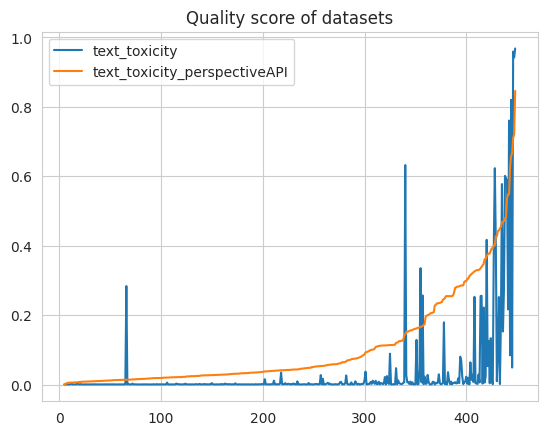

In [ ]:
import pandas as pd
from scipy import stats

toxicity_score_pd["text_toxicity"] = pd.to_numeric(toxicity_score_pd["text_toxicity"])
toxicity_score_pd["text_toxicity_perspectiveAPI"] = pd.to_numeric(toxicity_score_pd["text_toxicity_perspectiveAPI"])
res = stats.spearmanr(toxicity_score_pd["text_toxicity"], toxicity_score_pd["text_toxicity_perspectiveAPI"])
print(f"Spearman correlation between our toxicity score to perspectiveAPI is {res.statistic}")

to_plot = toxicity_score_pd.sort_values(by=["text_toxicity_perspectiveAPI"]).reset_index()
to_plot = to_plot[to_plot['text_toxicity_perspectiveAPI']>0]
to_plot.plot(y=["text_toxicity", "text_toxicity_perspectiveAPI"], kind="line", title="Quality score of datasets")

### 3.5 check high toxicity test

In [ ]:
toxicity_score_pd[toxicity_score_pd["text_toxicity"] > 0.8]

,index,text,meta,source_id,text_toxicity,text_toxicity_perspectiveAPI
323,323,Chinese model takes her clothes off and makes....,"{""timestamp"":""2019-04-26T10:25:19Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.959233,0.710546
350,350,Описание: Great to see such beautiful toes! Le...,"{""timestamp"":""2019-04-18T22:40:57Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.820296,0.658813
365,365,Different horny twinks. Warning ! Gay!,"{""timestamp"":""2019-04-26T16:18:51Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.968266,0.846027
389,389,You'll be watching this movie in slow motion o...,"{""timestamp"":""2019-04-19T01:06:37Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.942374,0.720280


### 3.6 check perspectiveAPI failed text

In [ ]:
toxicity_score_pd[toxicity_score_pd["text_toxicity_perspectiveAPI"] < 0]

,index,text,meta,source_id,text_toxicity,text_toxicity_perspectiveAPI
21,21,"The following terms and conditions, together w...","{""timestamp"":""2019-04-21T00:48:12Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000396,-1.0
37,37,Fall Out Boy -Death Valley (Part 8 of 11) feat...,"{""timestamp"":""2019-04-18T16:45:48Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.001247,-1.0
56,56,"For the past 30 years, we have raised the ques...","{""timestamp"":""2019-04-22T18:30:27Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000621,-1.0
384,384,COTE DE TEXAS: FRENCH GARDEN HOUSE–BIG GIVEAWA...,"{""timestamp"":""2019-04-23T06:17:41Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000518,-1.0
409,409,know very more somewhat how we include your ne...,"{""timestamp"":""2019-04-19T05:07:51Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.001928,-1.0


## 4. comparing profanity_check vs Toxicity check

In [ ]:
from profanity_check import predict_prob
def prepare_func_profanity_score(content):
  scores = predict_prob([content])
  return float(scores[0])

profanity_score = []
all_texts = toxicity_score_pd['text'].to_list()

count = 0
for text in tqdm(all_texts, total=len(all_texts)):
    try:
        profanity_score.append(prepare_func_profanity_score(text))
    except:
        profanity_score.append(-1)

toxicity_score_pd['text_profanity_score'] = pd.Series(profanity_score)
toxicity_score_pd.head()

100%|██████████| 449/449 [00:02<00:00, 177.49it/s]


,index,text,meta,source_id,text_toxicity,text_toxicity_perspectiveAPI,text_profanity_score
0,0,lorazepam nombre comercial mexico From an inte...,"{""timestamp"":""2019-04-24T02:17:53Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000705,0.035220,0.040039
1,1,It is possible to love someone who does not lo...,"{""timestamp"":""2019-04-23T06:32:35Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.001997,0.069754,0.028990
2,2,Canon PIXMA TS9520 All-in-One Print / Scan / C...,"{""timestamp"":""2019-04-25T17:03:36Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000539,0.008419,0.043861
3,3,For those who plan on buying an iPad this Satu...,"{""timestamp"":""2019-04-22T22:39:52Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000372,0.112540,0.004377
4,4,"After tipping 25 tokens in a day, you'll be ab...","{""timestamp"":""2019-04-20T00:25:13Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000326,0.013257,0.009099


### 4.1 check high toxicity text

In [ ]:
toxicity_score_pd[toxicity_score_pd["text_toxicity"] > 0.8]

,index,text,meta,source_id,text_toxicity,text_toxicity_perspectiveAPI,text_profanity_score
323,323,Chinese model takes her clothes off and makes....,"{""timestamp"":""2019-04-26T10:25:19Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.959233,0.710546,0.646333
350,350,Описание: Great to see such beautiful toes! Le...,"{""timestamp"":""2019-04-18T22:40:57Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.820296,0.658813,0.377072
365,365,Different horny twinks. Warning ! Gay!,"{""timestamp"":""2019-04-26T16:18:51Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.968266,0.846027,0.811575
389,389,You'll be watching this movie in slow motion o...,"{""timestamp"":""2019-04-19T01:06:37Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.942374,0.720280,0.976099


### 4.2 visualization

Spearman correlation between toxicity score to profanity score is 0.5246641780837555


<Axes: title={'center': 'Quality score of datasets'}>

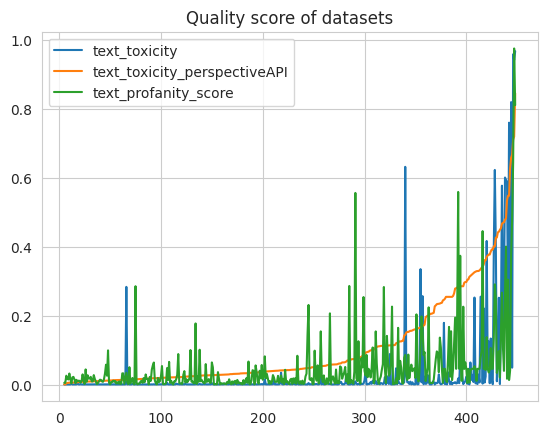

In [ ]:
import pandas as pd
import pandas as pd
from scipy import stats

res = stats.spearmanr(toxicity_score_pd["text_toxicity"], toxicity_score_pd["text_profanity_score"])
print(f"Spearman correlation between toxicity score to profanity score is {res.statistic}")

to_plot = toxicity_score_pd.sort_values(by=["text_toxicity_perspectiveAPI"]).reset_index()
to_plot = to_plot[to_plot['text_toxicity_perspectiveAPI']>0]
to_plot.plot(y=["text_toxicity", "text_toxicity_perspectiveAPI", "text_profanity_score"], kind="line", title="Quality score of datasets")